In [67]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from aeon.classification.convolution_based import RocketClassifier
from tsai.all import Learner
from tsai.all import InceptionTime
from tsai.models.InceptionTimePlus import InceptionTimePlus
from tsai.models.ResNet import ResNet
from tsai.models.XceptionTime import XceptionTime
from tsai.all import TSDataLoaders
from tsai.all import get_splits
from tsai.all import accuracy
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

from tsai.models.InceptionTime import InceptionBlock
from tsai.models.layers import GAP1d

In [68]:
def load_folder(folder_path, label):
    X_list = []
    y_list = []

    for fname in sorted(os.listdir(folder_path)):
        if fname.endswith(".csv"):
            df = pd.read_csv(os.path.join(folder_path, fname))
            df.columns = [c.strip() for c in df.columns]

            signal = df["Signal/nA"].values

            # reshape to (1, series_length) for Aeon
            X_list.append(signal.reshape(1, -1))
            y_list.append(label)

    return X_list, y_list


# Load each class
Xclear, yclear = load_folder(r"C:\Dev\MasterThesis\data\Si_wafer_clear_SRRs", label=0)
Xeth,   yeth   = load_folder(r"C:\Dev\MasterThesis\data\SRRs_cleaned_with_ethanol", label=1)
X10,    y10    = load_folder(r"C:\Dev\MasterThesis\data\SRRs_with_10ppb_Acetamiprid", label=2)
X100,   y100   = load_folder(r"C:\Dev\MasterThesis\data\SRRs_with_100ppb_Acetamiprid", label=3)
X1000,  y1000  = load_folder(r"C:\Dev\MasterThesis\data\SRRs_with_1000ppb_Acetamiprid", label=4)


# Combine them
X = np.array(Xclear + Xeth + X10 + X100 + X1000, dtype=object)
y = np.array(yclear + yeth + y10 + y100 + y1000)

# Define n_samples and series_length NOW
n_samples = len(X)
print("n_samples:", n_samples)

series_length = max(ts.shape[1] for ts in X)
print("series_length:", series_length)

# ------------------------------
# Pad to uniform length
# ------------------------------

X_padded = np.zeros((n_samples, 1, series_length))

for i, ts in enumerate(X):
    length = ts.shape[1]
    X_padded[i, 0, :length] = ts  # fill into padded array

print("X_padded shape:", X_padded.shape)
print("y shape:", len(y))


n_samples: 400
series_length: 4001
X_padded shape: (400, 1, 4001)
y shape: 400


### Baseline Classifier (ROCKET)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.2, random_state=42, stratify=y
)

# run the baseline classifier
clf = RocketClassifier(n_kernels=10000)
clf.fit(X_train, y_train)
print("ROCKET Accuracy:", clf.score(X_test, y_test))

ROCKET Accuracy: 0.8


Final X shape: (400, 1, 4001)


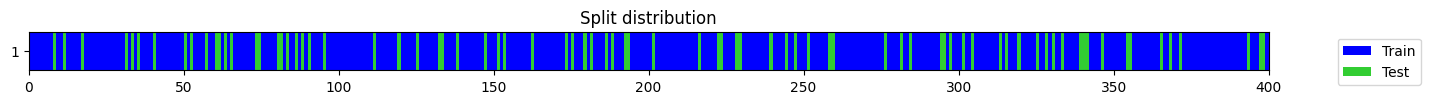

epoch,train_loss,valid_loss,accuracy,time
0,1.616024,1.617237,0.150000,00:48
1,1.614361,1.616339,0.150000,00:48
2,1.612925,1.616186,0.150000,00:48
3,1.611670,1.616468,0.150000,00:47
4,1.610196,1.616478,0.150000,00:47
5,1.608518,1.614810,0.150000,00:51
6,1.606491,1.611370,0.150000,00:52
7,1.601877,1.604347,0.187500,00:52
8,1.594433,1.799135,0.187500,00:52
9,1.585306,1.968435,0.187500,00:51


In [ ]:
# run Inception time
# InceptionTime model
# X: (400, 1, 4001)
# y: (400,)
def main():
    X = X_padded.astype(np.float32)

    # If wrong orientation, swap axes
    if X.shape[1] == series_length:
        X = np.swapaxes(X, 1, 2)

    print("Final X shape:", X.shape)  # (400, 1, 4001)

    y_int = y.astype(int)

    splits = get_splits(y_int, valid_size=0.2, shuffle=True)

    # dataloaders
    dls = TSDataLoaders.from_numpy(X, y_int, splits=splits, bs=64, num_workers=0)

    # create my model
    model = InceptionTime(
        c_in = 1,   # num channels = 1
        c_out=dls.c      # num classes
    )

    # learner
    learn = Learner(
        dls,
        model,
        metrics=[accuracy]
    )

    # train
    learn.fit_one_cycle(60, 1e-3)

    # evaluate
    learn.show_results()
    preds, targs = learn.get_preds()
    
    probs,_ = learn.get_preds()      # shape (N, num_classes)
    targs = targs                   # integer labels

    # one-hot for multiclass
    y_true = np.eye(probs.shape[1])[targs]

    print("\n--- AUC score per class ---")
    for c in range(probs.shape[1]):
        auc = roc_auc_score(y_true[:,c], probs[:,c])
        print(f"Class {c}: AUC = {auc:.3f}")


    # convert
    targs = targs.cpu().numpy()
    preds = preds.cpu().numpy().argmax(axis=1)

    class_names = [
        "Clear", 
        "Ethanol", 
        "Acetamiprid 10ppb", 
        "Acetamiprid 100ppb", 
        "Acetamiprid 1000ppb"
        ]

    fig = plt.gcf()
    axes = fig.axes   # list of all subplot axes  

    for ax in axes:
        # get current index from the title (it already contains "sample X")
        title = ax.get_title()

        # extract number from "sample X"
        parts = title.split()
        if "sample" in parts:
            idx = int(parts[parts.index("sample") + 1])
        
            true_label = class_names[targs[idx]]
            pred_label = class_names[preds[idx]]

            ax.set_title(f"Validation sample {idx}\nTrue: {true_label} | Pred: {pred_label}")
            ax.set_xlabel("Time")
            ax.set_ylabel("Signal (nA)")

    print("Finished training.")

if __name__ == "__main__":
    main()
    

In [44]:
# -----------------------------------------------------
# 1. Data loader per folder
# -----------------------------------------------------

def load_folder(folder_path, label):
    X_list = []
    y_list = []
    
    for fname in sorted(os.listdir(folder_path)):
        if fname.endswith(".csv"):
            csv_path = os.path.join(folder_path, fname)
            df = pd.read_csv(csv_path)
            
            # make sure column name is consistent
            df.columns = [c.strip() for c in df.columns]
            
            # extract the signal
            signal = df["Signal/nA"].values   # (L,)
            
            X_list.append(signal.reshape(1, -1))  # -> (1, L)
            y_list.append(label)
            
    return X_list, y_list



# -----------------------------------------------------
# 2. folders and labels
# -----------------------------------------------------

DATA_PATHS = {
    0: r"C:\Dev\MasterThesis\data\Si_wafer_clear_SRRs",
    1: r"C:\Dev\MasterThesis\data\SRRs_cleaned_with_ethanol",
    2: r"C:\Dev\MasterThesis\data\SRRs_with_10ppb_Acetamiprid",
    3: r"C:\Dev\MasterThesis\data\SRRs_with_100ppb_Acetamiprid",
    4: r"C:\Dev\MasterThesis\data\SRRs_with_1000ppb_Acetamiprid"
}



# -----------------------------------------------------
# 3. load whole dataset
# -----------------------------------------------------

X = []
y = []

for label, path in DATA_PATHS.items():
    Xi, yi = load_folder(path, label)
    X += Xi
    y += yi

X = np.array(X, dtype=object)           # list of (1, L)
y = np.array(y, dtype=int)

print("Samples:", len(X))



# -----------------------------------------------------
# 4. pad all signals to the SAME length
# -----------------------------------------------------

series_length = max(ts.shape[1] for ts in X)
print("Max series length:", series_length)

X_padded = np.zeros((len(X), 1, series_length))
for i, ts in enumerate(X):
    L = ts.shape[1]
    X_padded[i, 0, :L] = ts



# -----------------------------------------------------
# 5. reshape to N, length, channels  (tsai format)
# -----------------------------------------------------

X_tsai = np.swapaxes(X_padded, 1, 2).astype(np.float32)  # (N, L, 1)
y_tsai = y.copy()

print("Final shape:", X_tsai.shape)   # (N, L, C)


# -----------------------------------------------------
# 6. model parameters used by all networks
# -----------------------------------------------------

c_in = 1                              # 1 channel
c_out = len(np.unique(y_tsai))        # number of classes
seq_len = X_tsai.shape[1]             # input length (4001)

# -----------------------------------------------------
# 7. 10-fold cross validation function
# -----------------------------------------------------


def cross_validate(model_cls, X, y, n_splits=10, epochs=20, **model_kwargs):
    print(f"\nRunning {n_splits}-fold CV for: {model_cls.__name__}")
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_accs = []

    # X must be (N, 1, L)
    X = X.astype(np.float32)
    y = y.astype(int)

    for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
        print(f"Fold {fold+1}/{n_splits}")

        # convert each fold to tsai format
        X_train = np.swapaxes(X[train_idx], 1, 2)
        X_valid = np.swapaxes(X[valid_idx], 1, 2)

        dls = TSDataLoaders.from_numpy(
            np.concatenate([X_train, X_valid]),
            np.concatenate([y[train_idx], y[valid_idx]]),
            splits=(list(range(len(X_train))), list(range(len(X_train), len(X_train)+len(X_valid)))),
            bs=32,
            num_workers=0
        )

        model = model_cls(c_in=1, c_out=len(np.unique(y)), **model_kwargs)

        learn = Learner(dls, model, metrics=accuracy)
        learn.fit_one_cycle(epochs, 1e-3)

        acc = learn.recorder.values[-1][2]
        fold_accs.append(acc)
        print(f"Fold {fold+1} acc={acc:.4f}")

    print("\nFinal results:", np.mean(fold_accs), "±", np.std(fold_accs))
    return fold_accs

Samples: 400
Max series length: 4001
Final shape: (400, 4001, 1)


In [ ]:
#cross_validate(InceptionTimePlus, X_tsai, y_tsai, epochs = 5)



Running 10-fold CV for: InceptionTimePlus
Fold 1/10


epoch,train_loss,valid_loss,accuracy,time
0,1.619007,1.609369,0.212500,00:52
1,1.613857,1.605450,0.175000,00:51
2,1.600852,1.605965,0.212500,00:52
3,1.576368,1.612346,0.212500,00:56
4,1.551276,1.509615,0.300000,00:53


Fold 1 acc=0.3000
Fold 2/10


epoch,train_loss,valid_loss,accuracy,time
0,1.617515,1.609398,0.200000,00:52
1,1.613718,1.613728,0.200000,00:51
2,1.598663,1.655088,0.200000,00:51
3,1.579542,1.598658,0.200000,00:50
4,1.559586,1.515898,0.237500,00:51


Fold 2 acc=0.2375
Fold 3/10


epoch,train_loss,valid_loss,accuracy,time
0,1.617274,1.606313,0.225000,00:55
1,1.617572,1.607862,0.225000,00:56
2,1.609506,1.596200,0.200000,00:56
3,1.588101,1.590960,0.225000,00:56
4,1.566573,1.531892,0.275000,00:57


Fold 3 acc=0.2750
Fold 4/10


epoch,train_loss,valid_loss,accuracy,time
0,1.618382,1.606452,0.225000,00:57
1,1.613531,1.602290,0.200000,00:56
2,1.608399,1.607682,0.225000,00:55
3,1.592214,1.625751,0.225000,00:50
4,1.573622,1.524174,0.375000,00:51


Fold 4 acc=0.3750
Fold 5/10


epoch,train_loss,valid_loss,accuracy,time
0,1.616479,1.612703,0.187500,00:51
1,1.614770,1.605492,0.200000,00:50
2,1.600133,1.623743,0.187500,00:50
3,1.574102,1.606889,0.187500,00:53
4,1.549346,1.516037,0.337500,00:57


Fold 5 acc=0.3375
Fold 6/10


epoch,train_loss,valid_loss,accuracy,time
0,1.616126,1.611539,0.200000,00:56
1,1.615176,1.621494,0.175000,00:55
2,1.612192,1.616248,0.175000,00:56
3,1.605982,1.599895,0.175000,00:55
4,1.598044,1.589757,0.312500,00:55


Fold 6 acc=0.3125
Fold 7/10


epoch,train_loss,valid_loss,accuracy,time
0,1.624437,1.605042,0.237500,00:55
1,1.619037,1.612455,0.200000,00:55
2,1.615123,1.604035,0.200000,00:50
3,1.609187,1.596699,0.400000,00:50
4,1.602667,1.588446,0.400000,00:50


Fold 7 acc=0.4000
Fold 8/10


epoch,train_loss,valid_loss,accuracy,time
0,1.616259,1.606952,0.225000,00:51
1,1.617021,1.608328,0.175000,00:52
2,1.611302,1.599038,0.212500,00:56
3,1.600096,1.578705,0.225000,00:56
4,1.587153,1.563297,0.387500,00:56


Fold 8 acc=0.3875
Fold 9/10


epoch,train_loss,valid_loss,accuracy,time
0,1.619386,1.611536,0.212500,00:56
1,1.615462,1.608538,0.175000,00:56
2,1.603828,1.643236,0.212500,00:56
3,1.580335,1.732869,0.212500,00:56
4,1.558896,1.523520,0.250000,00:56


Fold 9 acc=0.2500
Fold 10/10


epoch,train_loss,valid_loss,accuracy,time
0,1.617810,1.609413,0.212500,00:56
1,1.613365,1.604549,0.187500,00:56
2,1.600374,1.999069,0.212500,00:56
3,1.576770,1.666110,0.212500,00:56
4,1.555231,1.531752,0.212500,00:56


Fold 10 acc=0.2125

Final results: 0.30875000208616254 ± 0.062262045597066294


[0.30000001192092896,
 0.23749999701976776,
 0.2750000059604645,
 0.375,
 0.3375000059604645,
 0.3125,
 0.4000000059604645,
 0.38749998807907104,
 0.25,
 0.21250000596046448]

### InceptionTimePlus

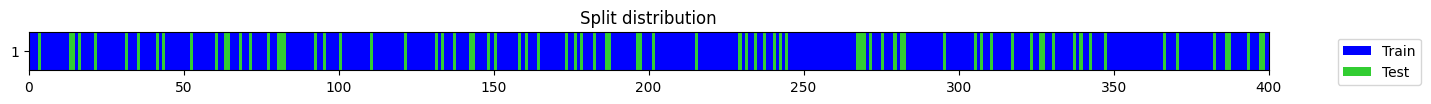

epoch,train_loss,valid_loss,accuracy,time
0,1.617719,1.610928,0.187500,00:57
1,1.614208,1.609858,0.187500,00:57
2,1.611510,1.609538,0.187500,00:55
3,1.609574,1.609336,0.187500,00:56
4,1.606992,1.608220,0.187500,00:53
5,1.601306,1.602687,0.187500,00:53
6,1.591481,1.770738,0.187500,00:56
7,1.579687,2.313913,0.187500,01:03
8,1.568727,2.827963,0.187500,01:09
9,1.559103,2.711360,0.187500,01:05


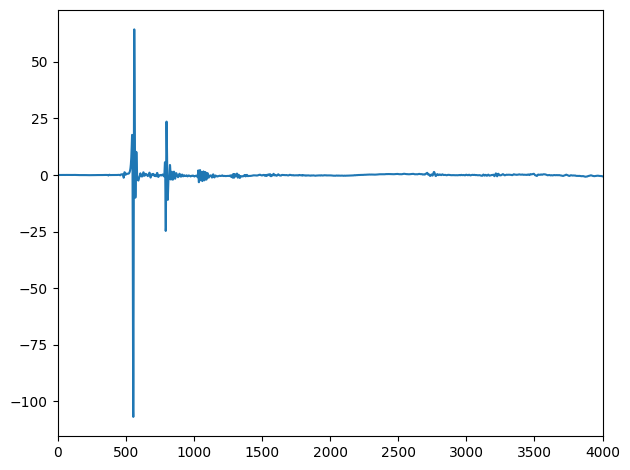

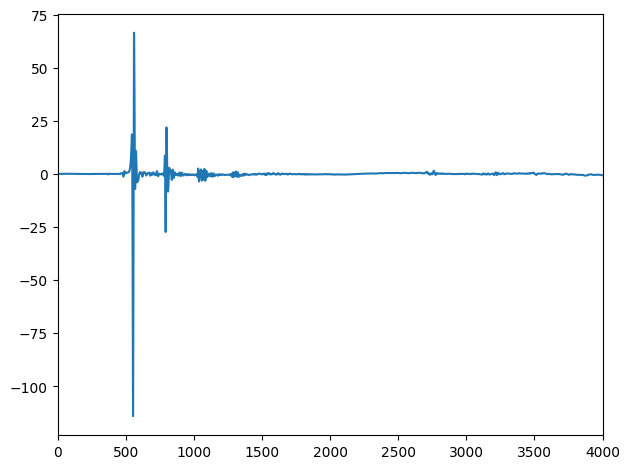

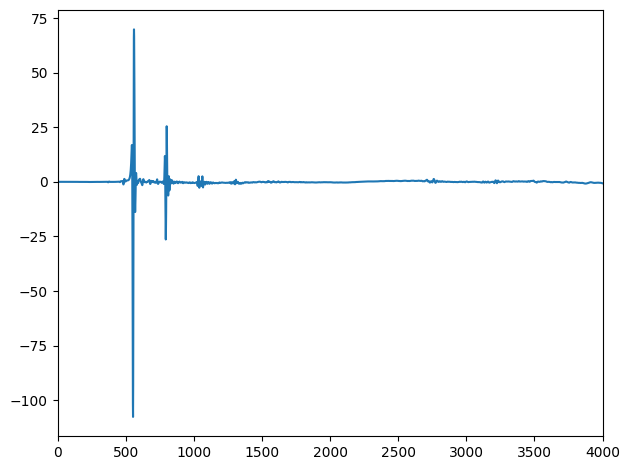

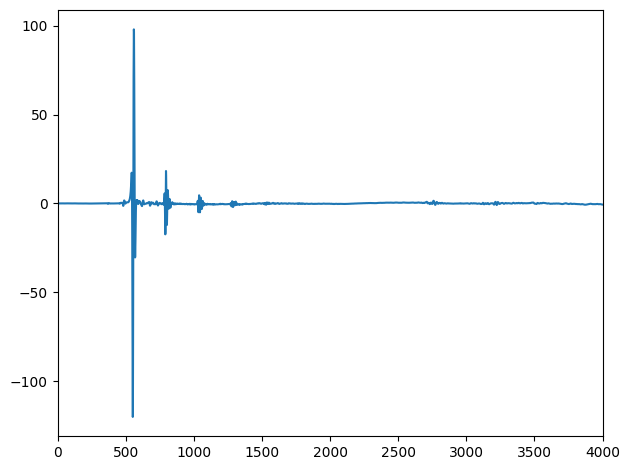

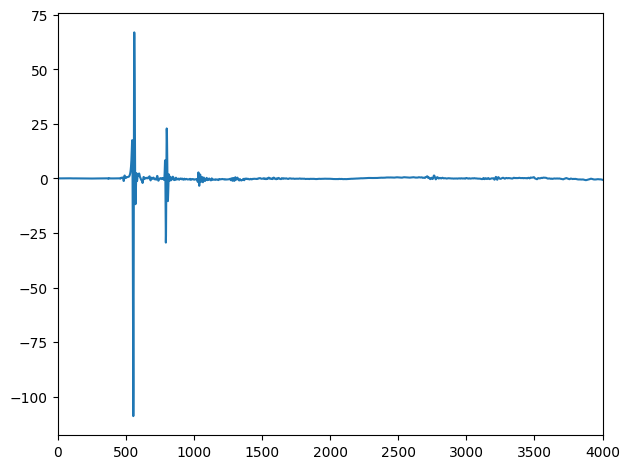

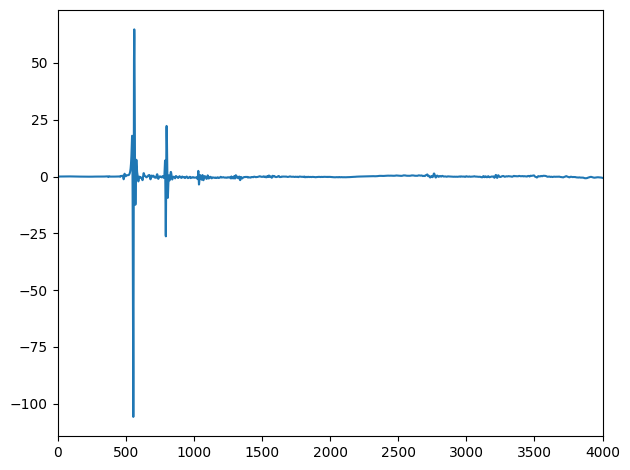

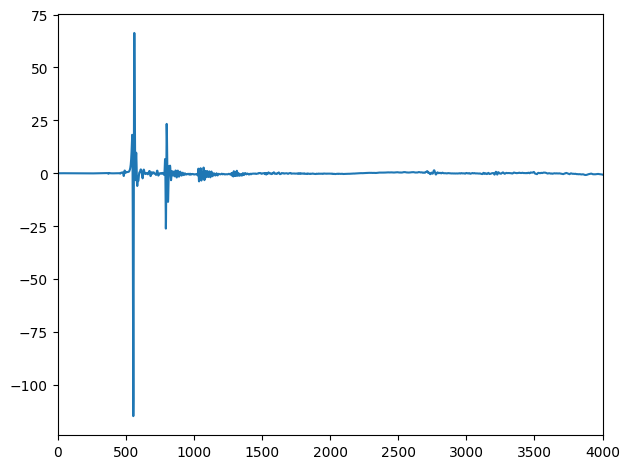

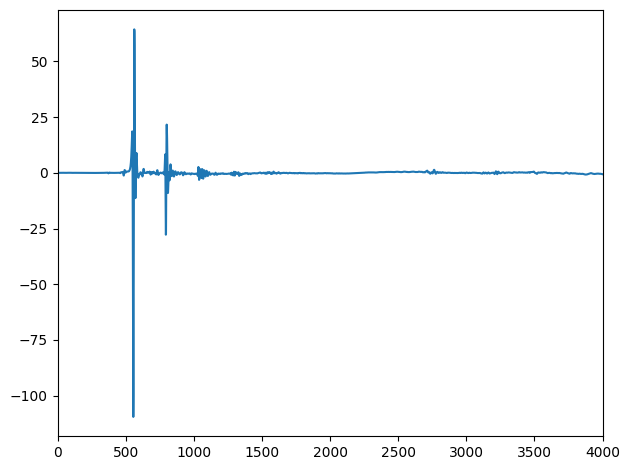

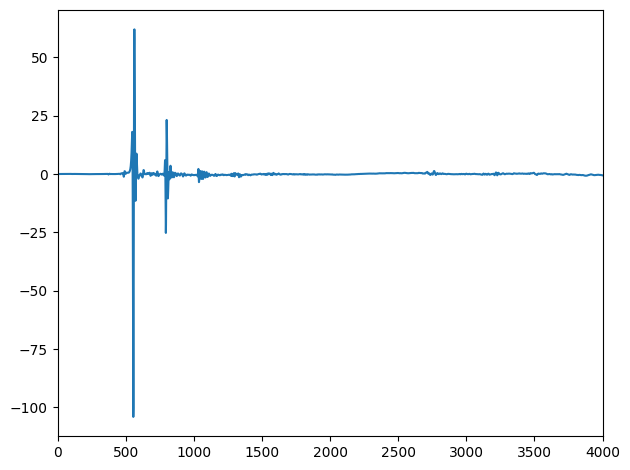

In [45]:

X_model = X_padded.astype(np.float32)     # (N,1,L)

splits = get_splits(y_tsai, valid_size=0.2, shuffle=True)

dls = TSDataLoaders.from_numpy(
        X_model, y_tsai, splits=splits,
        bs=64, num_workers=0
    )
model = InceptionTimePlus(c_in=c_in, c_out=c_out)
learn = Learner(dls, model, metrics=accuracy)
learn.fit_one_cycle(50, 1e-3)
learn.show_results()


In [52]:
learn.get_preds()
learn.export()

### ROC-AUC

In [46]:

# preds.shape = (N, 5)  -> softmax probabilities
preds, targs = learn.get_preds()
preds = preds.numpy()
y_true = targs.numpy()


In [47]:
classes = np.unique(y_true)          # e.g. [0,1,2,3,4]
n_classes = len(classes)

# Convert y to one-vs-rest matrix
y_bin = label_binarize(y_true, classes=classes)


In [48]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


In [49]:
for i in range(n_classes):
    print(f"Class {i}: AUC = {roc_auc[i]:.3f}")


Class 0: AUC = 0.934
Class 1: AUC = 0.802
Class 2: AUC = 1.000
Class 3: AUC = 0.812
Class 4: AUC = 0.821


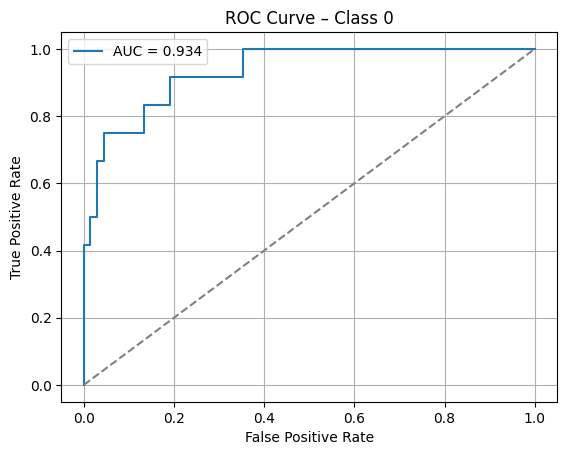

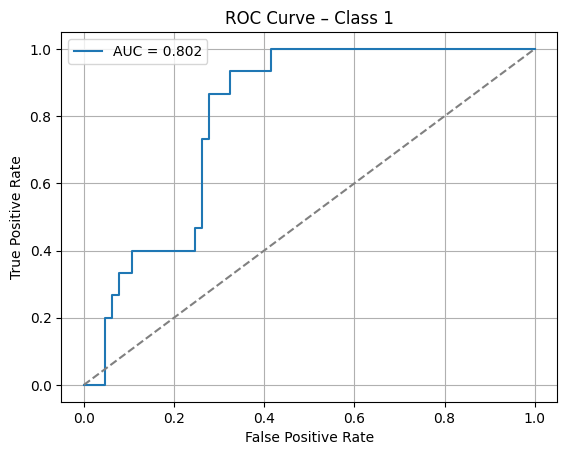

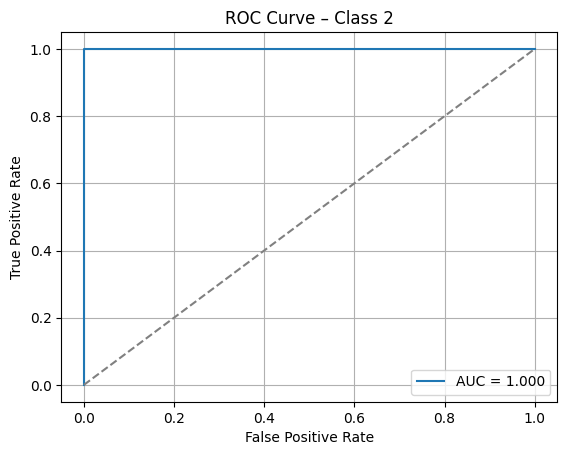

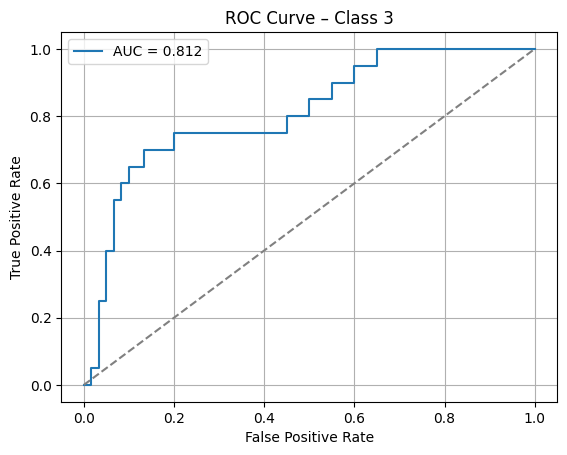

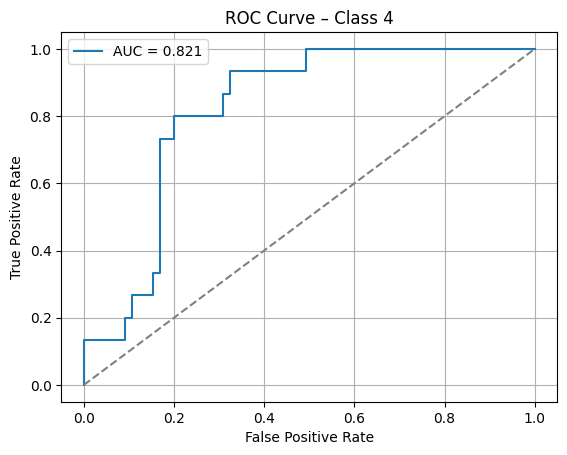

In [50]:
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label=f'AUC = {roc_auc[i]:.3f}')
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.title(f'ROC Curve – Class {i}')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()




epoch,train_loss,valid_loss,accuracy,time
0,1.616729,1.613197,0.187500,00:23
1,1.612350,1.614052,0.187500,00:22
2,1.608434,1.612559,0.187500,00:22
3,1.605691,1.610198,0.250000,00:22
4,1.599300,1.603205,0.187500,00:22
5,1.586275,1.582337,0.187500,00:22
6,1.572637,1.674520,0.187500,00:22
7,1.551322,1.538691,0.225000,00:22
8,1.530206,2.066670,0.225000,00:22
9,1.506688,1.448008,0.300000,00:22


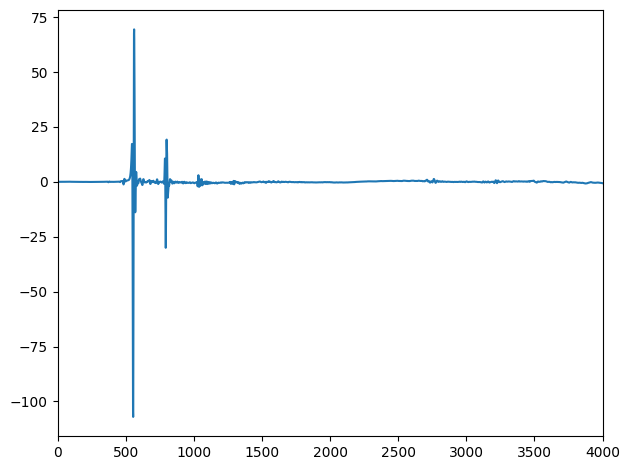

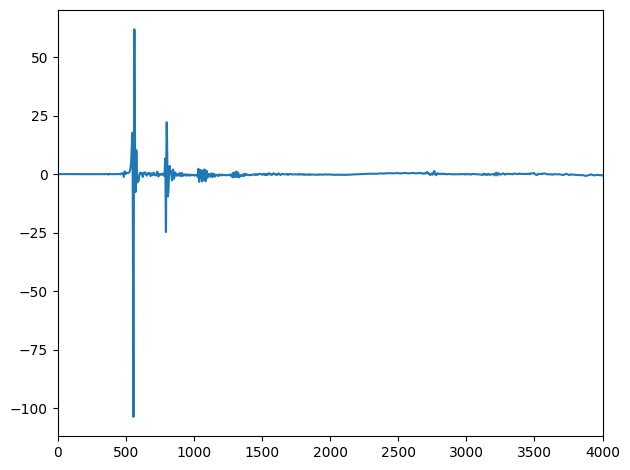

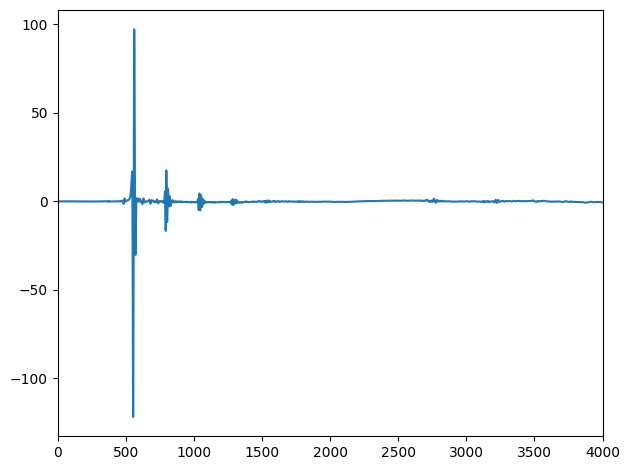

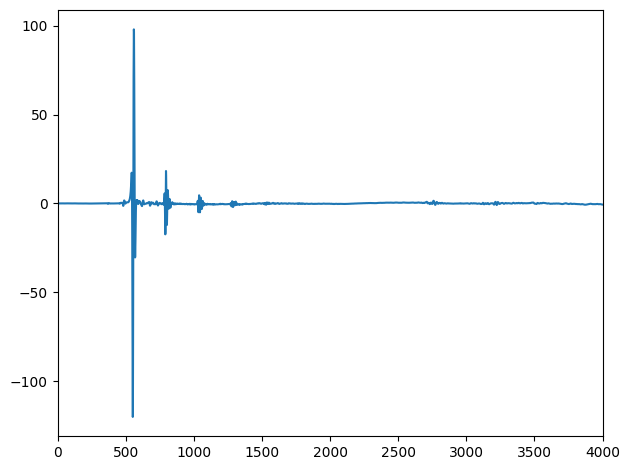

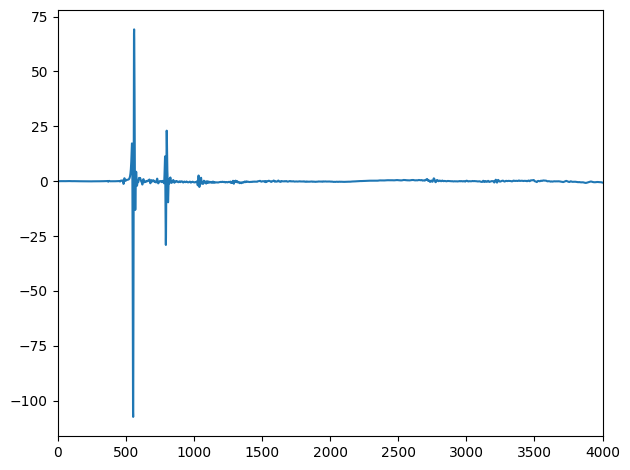

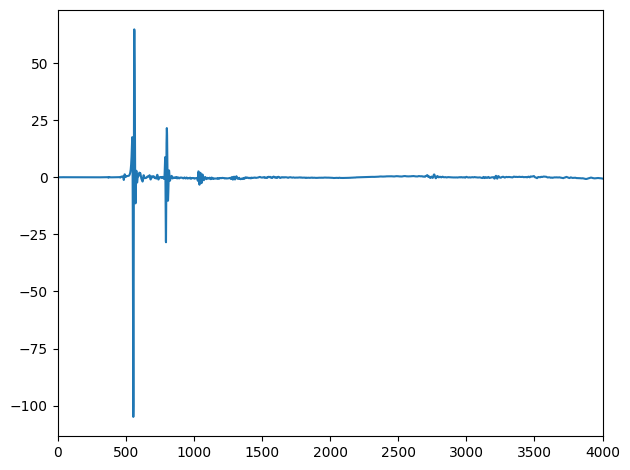

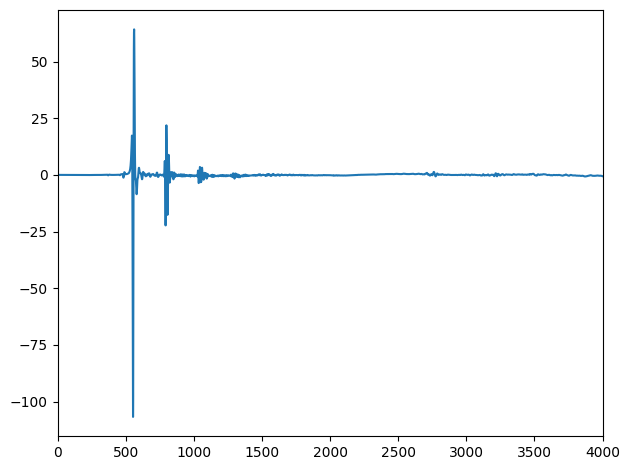

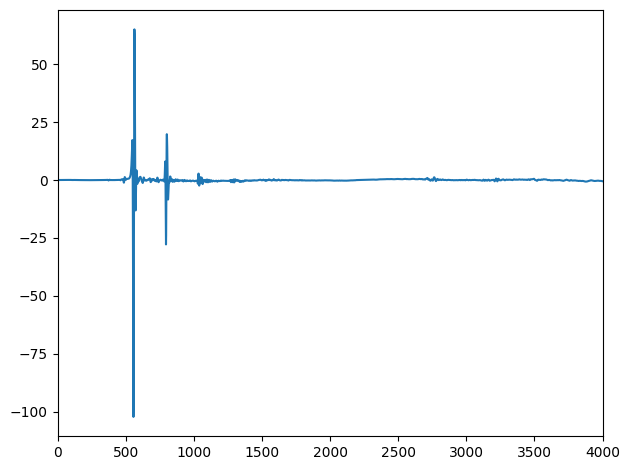

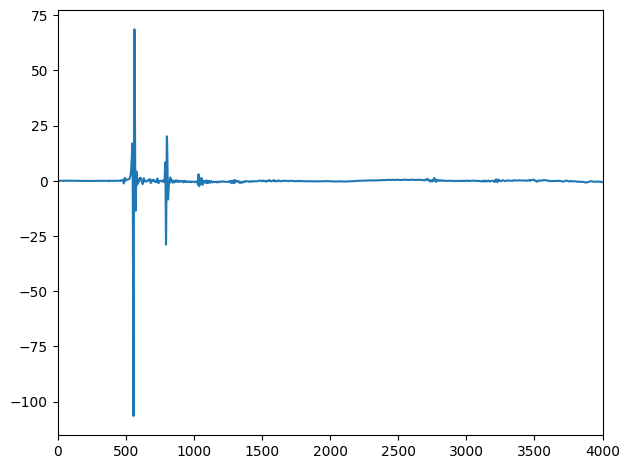

In [ ]:
model = ResNet(c_in=c_in, c_out=c_out)
learn = Learner(dls, model, metrics=accuracy)
learn.fit_one_cycle(30, 1e-3)
learn.show_results()
